# Illustration of audio transforms

<a href="https://gitee.com/mindspore/mindspore/blob/master/docs/api/api_python/dataset_audio/audio_gallary.ipynb" target="_blank"><img src="https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.png"></a>

This example illustrates the various transforms available in the [mindspore.dataset.audio](https://www.mindspore.cn/docs/en/master/api_python/mindspore.dataset.transforms.html#module-mindspore.dataset.audio) module.

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from IPython.display import Audio
from download import download

import mindspore.dataset as ds
import mindspore.dataset.audio as audio

ds.config.set_seed(5)

# cication: LibriSpeech http://www.openslr.org/12
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/84-121123-0000.wav"
download(url, './84-121123-0000.wav', replace=True)
wav_file = "84-121123-0000.wav"

def plot_waveform(waveform, sr, title="Waveform"):
    if waveform.ndim == 1:
        waveform = waveform[np.newaxis, :]
    num_channels, num_frames = waveform.shape
    time_axis = np.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    _, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)



file_sizes: 100%|███████████████████████████| 67.0k/67.0k [00:00<00:00, 894kB/s]
Successfully downloaded file to ./84-121123-0000.wav


## Spectrogram

To get the frequency make-up of an audio signal as it varies with time,
you can use :class:`dataset.audio.Spectrogram`.

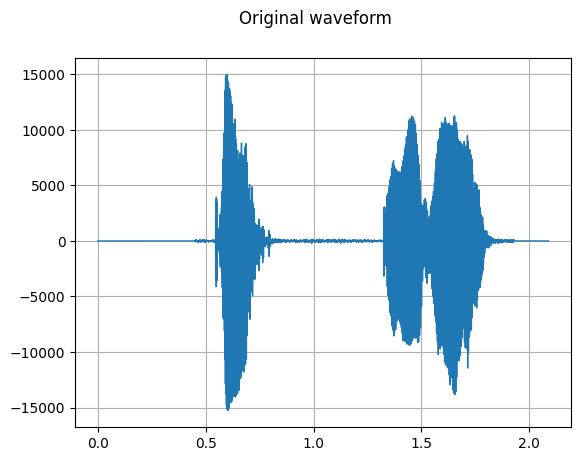

In [2]:
sample_rate, waveform = wavfile.read(wav_file)

plot_waveform(waveform, sample_rate, title="Original waveform")
Audio(waveform, rate=sample_rate)

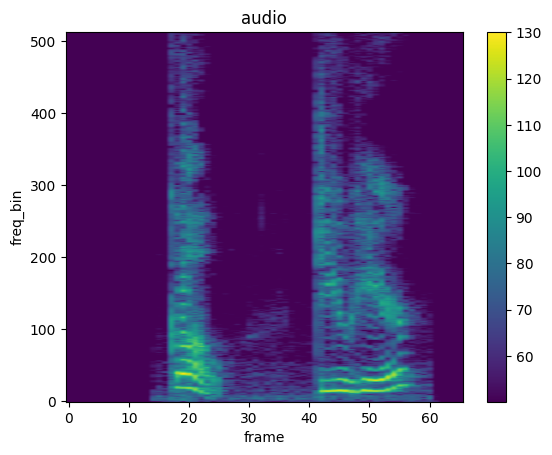

In [8]:
# Perform transform
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = audio.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode=audio.BorderType.REFLECT,
    power=2.0,
)

spec = spectrogram(waveform)
plot_spectrogram(spec, title="audio")

## GriffinLim

To recover a waveform from a spectrogram, you can use :class:`dataset.audio.GriffinLim`.

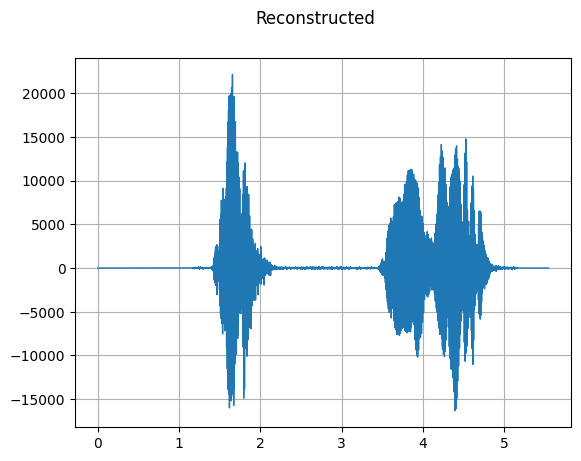

In [9]:
n_fft = 1024
win_length = None
hop_length = 512

spec = audio.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(waveform)

griffin_lim = audio.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

reconstructed_waveform = griffin_lim(spec)

plot_waveform(reconstructed_waveform, sample_rate, title="Reconstructed")
Audio(reconstructed_waveform, rate=sample_rate)

## Mel Filter Bank

:py:func:`dataset.vision.melscale_fbanks` generates the filter bank
for converting frequency bins to mel-scale bins.

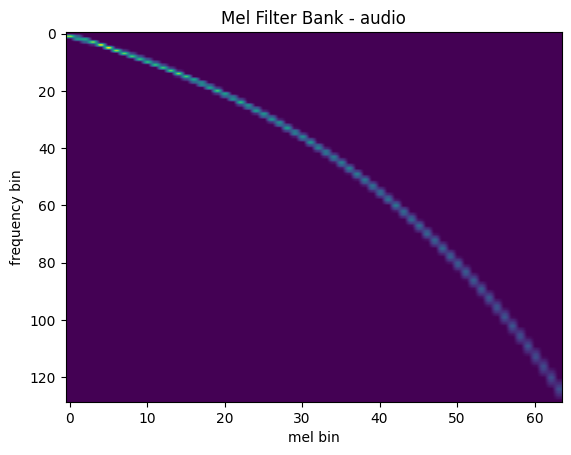

In [10]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = audio.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm=audio.NormType.SLANEY,
)

plot_fbank(mel_filters, "Mel Filter Bank - audio")

## MelSpectrogram

Generating a mel-scale spectrogram involves generating a spectrogram and performing mel-scale conversion.

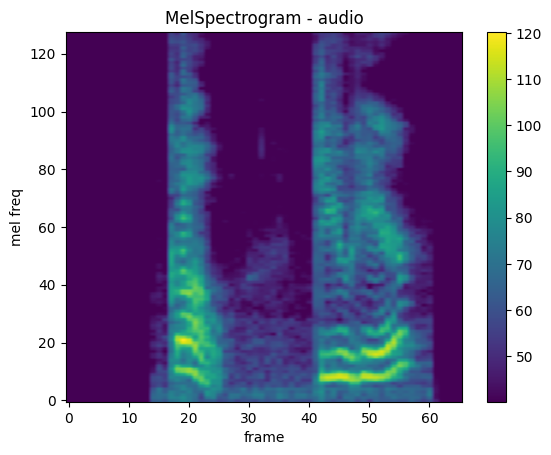

In [11]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = audio.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode=audio.BorderType.REFLECT,
    power=2.0,
    norm=audio.NormType.SLANEY,
    onesided=True,
    n_mels=n_mels,
    mel_scale=audio.MelType.HTK,
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec, title="MelSpectrogram - audio", ylabel="mel freq")

## MFCC

Create MFCC for a raw audio signal.

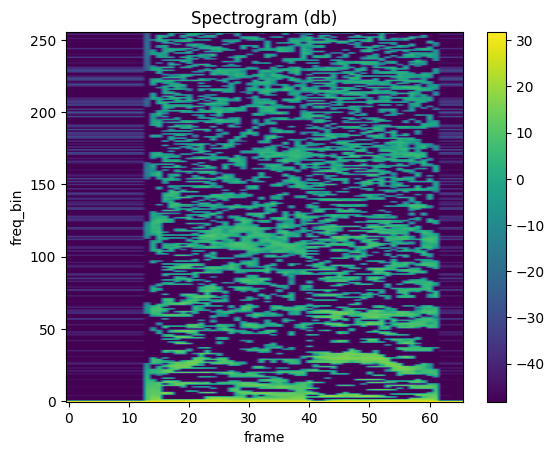

In [12]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = audio.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "win_length": n_fft,
        "f_min": 0.0,
        "f_max": sample_rate // 2,
        "pad": 0,
        "pad_mode": audio.BorderType.REFLECT,
        "power": 2.0,
        "n_mels": n_mels,
        "normalized": False,
        "center": True,
        "onesided": True,
        "window": audio.WindowType.HANN,
        "hop_length": hop_length,
        "norm": audio.NormType.NONE,
        "mel_scale": audio.MelType.HTK,
    },
)

mfcc = mfcc_transform(waveform)
plot_spectrogram(mfcc)

## LFCC

Create LFCC for a raw audio signal.


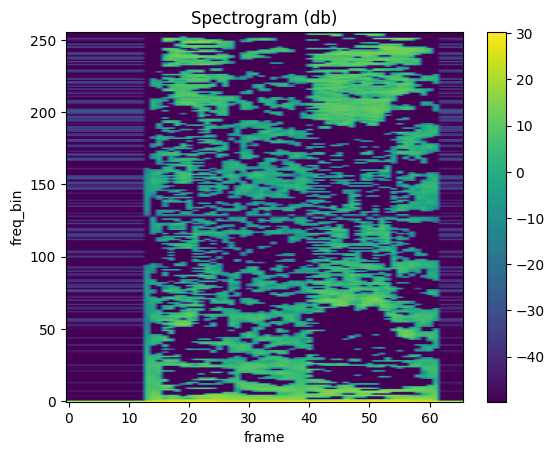

In [13]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = audio.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": n_fft,
        "hop_length": hop_length,
        "pad": 0,
        "window": audio.WindowType.HANN,
        "power": 2.0,
        "normalized": False,
        "center": True,
        "pad_mode": audio.BorderType.REFLECT,
        "onesided": True
    },
)

lfcc = lfcc_transform(waveform)
plot_spectrogram(lfcc)